## Prediction of store sales

In [32]:
import sys
import pandas as pd
sys.path.append('../scripts')
from data_preprocessing import load_data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

#### Initialize logger

In [33]:
# Initialize logger
logging.basicConfig(filename='../logs/prediction.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

#### load data

In [34]:
test_file_path = '../data/test.csv'
train_file_path = '../data/train.csv'
store_file_path = '../data/store.csv'

In [35]:
test_df=load_data(test_file_path)
train_df=load_data(train_file_path)
store_df=load_data(store_file_path)

c:\Users\zelalem.wubet\projects\personal\ten-academy\new\Sales_Forecasting_Rossmann_Pharmaceuticals\notebooks\../scripts\data_preprocessing.py:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


#### merge train and test data with store data

In [36]:
train_df  = train_df.merge(store_df, how='left', on='Store')
test_df = test_df.merge(store_df, how='left', on='Store')

In [37]:
train_df['Date'] = pd.to_datetime(train_df.Date)
test_df['Date'] = pd.to_datetime(test_df.Date)

In [38]:
# train_df['StateHoliday'] = train_df['StateHoliday'].astype('category')
# test_df['StateHoliday'] = test_df['StateHoliday'].astype('category')


## Preprocessing

#### Extract Features from Datetime Columns

In [39]:
# Extracting features from date
train_df['Day'] = train_df['Date'].dt.day
train_df['Weekday'] = train_df['Date'].dt.weekday
train_df['IsWeekend'] = train_df['Weekday'] >= 5
train_df['Month'] = train_df['Date'].dt.month
train_df['IsBeginningOfMonth'] = train_df['Day'] <= 10
train_df['IsMidMonth'] = (train_df['Day'] > 10) & (train_df['Day'] <= 20)
train_df['IsEndOfMonth'] = train_df['Day'] > 20
train_df['Year'] = train_df.Date.dt.year

In [40]:
test_df['Day'] = test_df.Date.dt.day
test_df['Month'] = test_df.Date.dt.month
test_df['Year'] = test_df.Date.dt.year

In [41]:
# # Feature: beginning, mid, and end of the month
# train_df['MonthPeriod'] = train_df['Day'].apply(lambda x: 'beginning' if x <= 10 else ('middle' if x <= 20 else 'end'))

# # Encode the 'MonthPeriod' feature as numerical
# train_df['MonthPeriod'] = train_df['MonthPeriod'].map({'beginning': 1, 'middle': 2, 'end': 3})

In [42]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Weekday', 'IsWeekend',
       'Month', 'IsBeginningOfMonth', 'IsMidMonth', 'IsEndOfMonth', 'Year'],
      dtype='object')

In [43]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'Day', 'Month', 'Year']
target_col = 'Sales'



train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)
unique_values = train_df['StateHoliday'].unique()
print(unique_values)

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()


numeric_cols = ['Store', 'Day', 'Month', 'Year']
categorical_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment']

test_inputs = test_df[input_cols].copy()

['0' 'a' 'b' 'c']


### handle missing value

In [44]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean').fit(train_inputs[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

###  # Scale the data

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### # Convert categorical to numeric

In [46]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [47]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

### # Define the target variable and drop unnecessary columns

In [48]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [49]:
X_train.columns

Index(['Store', 'Day', 'Month', 'Year', 'DayOfWeek_1', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'Promo_0', 'Promo_1', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c'],
      dtype='object')

In [50]:
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Function to train, evaluate, and serialize a model
def train_evaluate_serialize_model(model, X_train, train_targets, test_size=0.2, random_state=42):
    # Step 1: Split the data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, train_targets, test_size=test_size, random_state=random_state
    )
    
    # Step 2: Fit the model on the training data
    model.fit(X_train_split, y_train_split)
    
    # Step 3: Make predictions on the validation data
    y_val_pred = model.predict(X_val_split)
    
    # Step 4: Evaluate the model using metrics like Mean Squared Error (MSE) and R-squared (R2)
    mse = mean_squared_error(y_val_split, y_val_pred)
    r2 = r2_score(y_val_split, y_val_pred)
    
    # Step 5: Serialize the model with a timestamp
    timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S-%f')
    model_filename = f'model_{timestamp}.pkl'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model, model_file)
    
    print(f"Model serialized as {model_filename}")
    
    # Step 6: Return the MSE, R-squared values, and the model filename
    return mse, r2, model_filename

In [27]:
# Example usage with Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Instantiate the DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)

# Train, evaluate, and serialize the Decision Tree model
mse, r2, model_filename = train_evaluate_serialize_model(dt_model, X_train, train_targets)

# Print the evaluation results
print(f"Decision Tree - Validation MSE: {mse}, R2: {r2}")
print(f"Serialized model saved as: {model_filename}")


Model serialized as model_23-09-2024-14-54-57-014540.pkl
Decision Tree - Validation MSE: 2443787.189606866, R2: 0.8347541502906082
Serialized model saved as: model_23-09-2024-14-54-57-014540.pkl


In [51]:
# Example usage with Random Forest
from sklearn.ensemble import RandomForestRegressor

# Instantiate a RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train, evaluate, and serialize the RandomForest model
mse, r2, model_filename = train_evaluate_serialize_model(rf_model, X_train, train_targets)

# Print the evaluation results
print(f"Random Forest - Validation MSE: {mse}, R2: {r2}")
print(f"Serialized model saved as: {model_filename}")

Model serialized as model_23-09-2024-21-12-21-174009.pkl
Random Forest - Validation MSE: 1393086.2023060962, R2: 0.9058012439882159
Serialized model saved as: model_23-09-2024-21-12-21-174009.pkl


### Feature importance

In [29]:
rf_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': numeric_cols+encoded_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
10,DayOfWeek_7,0.346864
0,Store,0.329737
13,StateHoliday_0,0.087559
11,Promo_0,0.041565
12,Promo_1,0.032657
18,StoreType_b,0.030655
1,Day,0.029350
2,Month,0.028235
4,DayOfWeek_1,0.017776
3,Year,0.009270


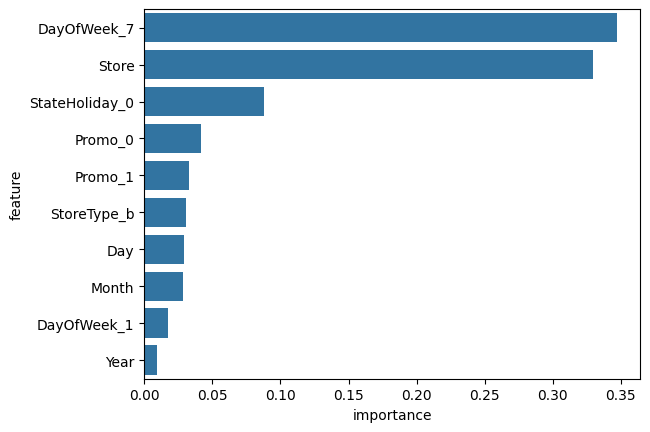

In [30]:

sns.barplot(data=importance_df.head(10), x='importance', y='feature');


In [32]:
# # Isolate Store and Sales columns for time series prediction
# store_sales_df = train_df[['Store', 'Date', 'Sales']].set_index('Date')


In [31]:
# from statsmodels.tsa.stattools import adfuller

# result = adfuller(store_sales_df['Sales'])
# print(f'ADF Statistic: {result[0]}')
# print(f'p-value: {result[1]}')


In [21]:
import numpy as np
from sklearn.metrics import r2_score

# Reshape input data to 3D for LSTM
X_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_lstm = train_targets.values

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=True),
    LSTM(50),
    Dense(1)   # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_lstm, y_lstm, epochs=20, batch_size=32)

# Predict using the test data
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape test data
y_pred = model.predict(X_test_lstm)




c:\Users\zelalem.wubet\projects\personal\ten-academy\new\Sales_Forecasting_Rossmann_Pharmaceuticals\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - loss: 5508.8633
Epoch 2/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 107s 3ms/step - loss: 4483.4614
Epoch 3/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 129s 4ms/step - loss: 3487.7322
Epoch 4/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 103s 3ms/step - loss: 2627.3950
Epoch 5/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 2066.9946
Epoch 6/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 89s 3ms/step - loss: 1794.5986
Epoch 7/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 1684.0280
Epoch 8/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 124s 4ms/step - loss: 1642.9377
Epoch 9/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 99s 3ms/step - loss: 1613.3416
Epoch 10/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - loss: 1597.6376
Epoch 11/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - loss: 1583.1588
Epoch 12/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - loss: 1576.6322
Epoch 13/20
31788/31788 ━━━━━━━━━━━━━━━━━━━━ 106s 3ms/step - loss: 1573.1040
Epoch 14/20
3

NameError: name 'test_targets' is not defined

In [23]:
model.save('lstm_sales_model.h5')

In [24]:
def predict_input(model, single_input):
    if single_input['Open'] == 0:
        return 0.
    input_df = pd.DataFrame([single_input])
    input_df['Date'] = pd.to_datetime(input_df.Date)
    input_df['Day'] = input_df.Date.dt.day
    input_df['Month'] = input_df.Date.dt.month
    input_df['Year'] = input_df.Date.dt.year
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    return pred

In [25]:
sample_input = {'Id': 1,
 'Store': 1,
 'DayOfWeek': 4,
 'Date': '2015-09-17 00:00:00',
 'Open': 1.0,
 'Promo': 1,
 'StateHoliday': '0',
 'SchoolHoliday': 0,
 'StoreType': 'c',
 'Assortment': 'a',
 'CompetitionDistance': 1270.0,
 'CompetitionOpenSinceMonth': 9.0,
 'CompetitionOpenSinceYear': 2008.0,
 'Promo2': 0,
 'Promo2SinceWeek': np.nan,
 'Promo2SinceYear': np.nan,
 'PromoInterval': np.nan}

sample_input

{'Id': 1,
 'Store': 1,
 'DayOfWeek': 4,
 'Date': '2015-09-17 00:00:00',
 'Open': 1.0,
 'Promo': 1,
 'StateHoliday': '0',
 'SchoolHoliday': 0,
 'StoreType': 'c',
 'Assortment': 'a',
 'CompetitionDistance': 1270.0,
 'CompetitionOpenSinceMonth': 9.0,
 'CompetitionOpenSinceYear': 2008.0,
 'Promo2': 0,
 'Promo2SinceWeek': nan,
 'Promo2SinceYear': nan,
 'PromoInterval': nan}

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

In [52]:
predict_input(rf_model, sample_input)

4288.04